In [1]:
import os
import matplotlib.pyplot as plt
import math

import pandas as pd
import numpy as np
from dotenv import load_dotenv
import datetime

from psycopg2 import sql, connect
from sqlalchemy import create_engine, text

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

from train_test.general import train_test_bookies_comparison, display_train_test_bookies_comparison, train_test
from train_test.split import train_test_split_expanding_windows, train_test_split_sliding_windows
from feature_eng.odds import bookie_prediction, prob_by_bookies
from train_test.metrics import accuracy_fn, classwise_ECE_fn, f_mesure_fn, log_loss_fn, mse_loss_fn, precision_fn, recall_fn
from feature_eng.team_stats import goal_stats, elo_scores, glicko2_scores, trueskill_scores

from feature_eng.format_df import merge_sofifa_fbref_results, format_sofifa_fbref_data, add_signals


In [2]:

load_dotenv("./../../secrets.env")
DB_USER = 'kube'
DB_PASSWORD = os.getenv('DB_PASSWORD')
DB_HOST = 'localhost'
DB_PORT = 8110
DB_NAME = 'optimsportbets-db'

DB_TN_FBREF_RESULTS = 'fbref_results'
DB_TN_ODDS = 'soccer_odds'
DB_TN_SOFIFA_TEAMS_STATS = 'sofifa_teams_stats'
DB_TN_MODELS_RESULTS = 'models_results'
DB_TN_OPTIM_RESULTS = 'optim_results'

In [3]:
connection_url = f'postgresql+psycopg2://{(DB_USER)}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
engine = create_engine(connection_url)

with engine.connect() as connection:
    query = text(f"SELECT * FROM {DB_TN_FBREF_RESULTS}")
    fbref_results_df = pd.read_sql(query, connection)
    sofifa_teams_stats_df = pd.read_sql(f'SELECT * FROM {DB_TN_SOFIFA_TEAMS_STATS}', connection)

In [4]:
date_stop = datetime.datetime.now()
fbref_results_df__sofifa_merged = merge_sofifa_fbref_results(fbref_results_df, sofifa_teams_stats_df)
fbref_results_df__sofifa_merged__data_formated = format_sofifa_fbref_data(fbref_results_df__sofifa_merged, date_stop=date_stop)
fbref_results_df__sofifa_merged__data_formated__signals_added = add_signals(fbref_results_df__sofifa_merged__data_formated, date_stop=date_stop)

rule_is_before_datetime = fbref_results_df__sofifa_merged__data_formated__signals_added["datetime"] < date_stop
fbref_results_df__sofifa_merged__data_formated__signals_added__train = fbref_results_df__sofifa_merged__data_formated__signals_added[rule_is_before_datetime]
fbref_results_df__sofifa_merged__data_formated__signals_added__infer = fbref_results_df__sofifa_merged__data_formated__signals_added[~rule_is_before_datetime]

In [5]:
X_col_sofifa =  ['home_overall', 'home_attack', 
            'home_midfield', 'home_defence', 'home_transfer_budget', 'home_club_worth', 'home_defence_domestic_prestige', 'home_international_prestige', 
            'home_players', 'home_starting_xi_average_age', 'home_whole_team_average_age', 'away_overall', 'away_attack', 'away_midfield', 'away_defence', 
            'away_transfer_budget', 'away_club_worth', 'away_defence_domestic_prestige', 'away_international_prestige', 'away_players', 
            'away_starting_xi_average_age', 'away_whole_team_average_age']

X_col_scores = [
    'elo_home_before', 'elo_away_before',
    'home_team_number_of_match_played', 'away_team_number_of_match_played',
    'glicko2_home_before', 'glicko2_away_before', 'glicko2_rd_home_before',
    'glicko2_rd_away_before', 'glicko2_vol_home_before',
    'glicko2_vol_away_before', 'trueskill_home_before',
    'trueskill_away_before', 'home_team_goals_season_to_date_before_match',
'away_team_goals_season_to_date_before_match',
'avg_home_team_goals_season_to_date_before_match',
'avg_away_team_goals_season_to_date_before_match']

X_cat = ['home_league',
 'home_build_up_speed',
 'home_build_up_dribbling',
 'home_build_up_passing',
 'home_build_up_positioning',
 'home_chance_creation_crossing',
 'home_chance_creation_passing',
 'home_chance_creation_shooting',
 'home_chance_creation_positioning',
 'home_defence_aggression',
 'home_defence_pressure',
 'home_defence_team_width',
 'home_defence_defender_line',
 'away_league',
 'away_build_up_speed',
 'away_build_up_dribbling',
 'away_build_up_passing',
 'away_build_up_positioning',
 'away_chance_creation_crossing',
 'away_chance_creation_passing',
 'away_chance_creation_shooting',
 'away_chance_creation_positioning',
 'away_defence_aggression',
 'away_defence_pressure',
 'away_defence_team_width',
 'away_defence_defender_line',]


Y_col = 'FTR'

# All features
df_cat_onehot = pd.get_dummies(fbref_results_df__sofifa_merged__data_formated__signals_added__train[X_cat], drop_first=True)
X_col = X_col + df_cat_onehot.columns.tolist()
df_all = pd.concat([fbref_results_df__sofifa_merged__data_formated__signals_added__train, df_cat_onehot], axis=1)

pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression())
    ])

features = [
    "elo_away_before",
    "elo_home_before",
    "glicko2_vol_away_before",
    "away_overall",
    "home_overall",
    "away_build_up_speed_Slow",
    "away_starting_xi_average_age",
    "home_league_INT",
    "avg_home_team_goals_season_to_date_before_match",
    "home_build_up_positioning_Organised",
    "home_build_up_speed_Fast",
    "away_defence_pressure_High",
    "away_defence_defender_line_Offside trap",
    "home_league_ITA-Serie A",
    "glicko2_rd_home_before",
    "home_chance_creation_shooting_Normal",
    "away_build_up_passing_Mixed",
    "away_team_goals_season_to_date_before_match",
    "home_chance_creation_passing_Risky",
    "away_chance_creation_positioning_Organised",
    "away_defence_pressure_Medium",
    "away_defence_domestic_prestige",
    "away_chance_creation_shooting_Lots",
    "home_defence_defender_line_Offside trap",
    "away_defence_team_width_Wide",
    "home_defence_pressure_Medium",
    "home_build_up_speed_Slow",
    "away_defence_aggression_Press",
    "trueskill_home_before",
    "away_build_up_positioning_Organised",
    "away_defence",
    "home_attack",
    "home_defence_domestic_prestige",
    "away_attack",
    "away_league_INT",
    "away_league_ITA-Serie A",
    "home_chance_creation_crossing_Normal",
    "home_defence_team_width_Wide",
    "away_players",
    "away_chance_creation_crossing_Normal",
    "glicko2_rd_away_before",
    "home_starting_xi_average_age",
    "home_whole_team_average_age",
    "away_chance_creation_passing_Risky",
    "away_chance_creation_passing_Safe",
    "away_chance_creation_shooting_Normal",
    "away_chance_creation_crossing_Lots",
    "away_defence_aggression_Double",
    "home_players",
    "away_build_up_speed_Fast",
    "away_transfer_budget",
    "home_team_goals_season_to_date_before_match",
    "home_team_number_of_match_played",
    "home_defence",
    "trueskill_away_before",
    "home_chance_creation_passing_Safe",
    "away_defence_team_width_Normal",
    "away_team_number_of_match_played",
    "home_club_worth",
    "away_build_up_dribbling_Normal",
    "home_build_up_passing_Short",
    "home_chance_creation_crossing_Lots",
    "away_club_worth",
    "home_build_up_dribbling_Normal",
    "home_build_up_dribbling_Lots",
    "home_defence_aggression_Press",
    "away_midfield",
    "glicko2_home_before",
    "away_whole_team_average_age",
    "away_build_up_passing_Short",
    "glicko2_vol_home_before",
    "glicko2_away_before",
    "avg_away_team_goals_season_to_date_before_match",
    "home_build_up_passing_Mixed",
    "home_transfer_budget",
    "home_chance_creation_positioning_Organised",
    "home_midfield",
    "home_defence_team_width_Normal",
    "home_defence_pressure_High",
    "home_league_ESP-La Liga",
    "away_league_ESP-La Liga",
    "away_build_up_dribbling_Lots",
    "home_defence_aggression_Double",
    "home_chance_creation_shooting_Lots",
    "away_international_prestige",
    "home_international_prestige"
]


In [7]:
feature_selected = features[:35]
X_col = feature_selected

In [25]:
date_stop_train = datetime.datetime(2010, 1, 1)
train = df_all[df_all['datetime'] < date_stop_train]
test = df_all[df_all['datetime'] >= date_stop_train]

result_col_name = 'FTR'
model_predictions_col_name = 'model_predictions'
model_predictions_prob_home_col_name = 'model_predictions_prob_home'
model_predictions_prob_draw_col_name = 'model_predictions_prob_draw'
model_predictions_prob_away_col_name = 'model_predictions_prob_away'

X_train = train[X_col]
Y_train = train[Y_col]
X_test = test[X_col]

pipeline.fit(X_train, Y_train.values.ravel())
predictions = pipeline.predict(X_test)
prob_predictions = pipeline.predict_proba(X_test)

result_df = test.copy()
result_df.loc[:, model_predictions_col_name] = predictions
result_df.loc[:, model_predictions_prob_home_col_name] = prob_predictions[:, 2]
result_df.loc[:, model_predictions_prob_draw_col_name] = prob_predictions[:, 1]
result_df.loc[:, model_predictions_prob_away_col_name] = prob_predictions[:, 0]

metrics = {}
metrics["accuracy"], metrics["weighted_accuracy"], (metrics["accuracy_home"], metrics["accuracy_draw"], metrics["accuracy_away"]) = accuracy_fn(result_df, result_col_name, model_predictions_col_name)
metrics["macro_avg_recall"], metrics["micro_avg_recall"], metrics["weighted_recall"], (metrics["recall_home"], metrics["recall_draw"], metrics["recall_away"]) = recall_fn(result_df, result_col_name, model_predictions_col_name)
metrics["macro_avg_precision"], metrics["micro_avg_precision"], metrics["weighted_precision"], (metrics["precision_home"], metrics["precision_draw"], metrics["precision_away"]) = precision_fn(result_df, result_col_name, model_predictions_col_name)
metrics["macro_avg_f_mesure"], metrics["micro_avg_f_mesure"], metrics["weighted_f_mesure"], (metrics["f_mesure_home"], metrics["f_mesure_draw"], metrics["f_mesure_away"]) = f_mesure_fn(result_df, result_col_name, model_predictions_col_name)
metrics["log_loss"], (metrics["loss_home"], metrics["loss_draw"], metrics["loss_away"]) = log_loss_fn(result_df[result_col_name], result_df[model_predictions_prob_home_col_name], result_df[model_predictions_prob_draw_col_name], result_df[model_predictions_prob_away_col_name], all_results=True)
metrics["mse"], (metrics["mse_home"], metrics["mse_draw"], metrics["mse_away"]) = mse_loss_fn(result_df[result_col_name], result_df[model_predictions_prob_home_col_name], result_df[model_predictions_prob_draw_col_name], result_df[model_predictions_prob_away_col_name], all_results=True)
metrics["classwise_ECE"], (metrics["ECE_home"], metrics["ECE_draw"], metrics["ECE_away"]), (metrics["home_ECE_y"], metrics["draw_ECE_y"], metrics["away_ECE_y"]), (metrics["home_ECE_p"], metrics["draw_ECE_p"], metrics["away_ECE_p"]), (metrics["home_ECE_size"], metrics["draw_ECE_size"], metrics["away_ECE_size"]) = classwise_ECE_fn(result_df[result_col_name], result_df[model_predictions_prob_home_col_name], result_df[model_predictions_prob_draw_col_name], result_df[model_predictions_prob_away_col_name], all_results=True)


In [26]:
print(f' MSE: {metrics["mse"]}')
print(f' Log Loss: {metrics["log_loss"]}')
print(f' Classwise ECE: {metrics["classwise_ECE"]}')
print(f' Accuracy Home: {metrics["accuracy_home"]}')
print(f' Accuracy Draw: {metrics["accuracy_draw"]}')
print(f' Accuracy Away: {metrics["accuracy_away"]}')
print(f' Accuracy: {metrics["accuracy"]}')

 MSE: 0.22013075909388166
 Log Loss: 1.1451502636709368
 Classwise ECE: 0.1143295667038801
 Accuracy Home: 0.6155772222011457
 Accuracy Draw: 0.7214992981524337
 Accuracy Away: 0.6337493835122728
 Accuracy: 0.48541295193292616


In [28]:
!pip install tqdm

     ---------------------------------------- 0.0/78.4 kB ? eta -:--:--
     ---------------------------------------- 78.4/78.4 kB 4.5 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [40]:
import uuid

In [71]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bar
# Import or define your model and preprocessing steps here

def evaluate_models_over_time(
    df_all,
    X_col,
    Y_col,
    preliminary_train_stop_date,
    evaluation_start_date,
    evaluation_end_date,
    pipeline,
    window_size_days=30
):
    """
    Evaluate Model A (no retraining) and Model B (daily retraining) over time.
    
    Parameters:
    - df_all: pandas DataFrame containing all data with a 'datetime' column.
    - X_col: list of feature column names.
    - Y_col: target column name (string).
    - preliminary_train_stop_date: date where initial training stops (string or datetime).
    - evaluation_start_date: start date for evaluation (string or datetime).
    - evaluation_end_date: end date for evaluation (string or datetime).
    - pipeline: your machine learning pipeline or model.
    
    Returns:
    - metrics_df_A: DataFrame containing rolling metrics for Model A.
    - metrics_df_B: DataFrame containing rolling metrics for Model B.
    """
    # Convert date strings to datetime objects if necessary
    preliminary_train_stop_date = pd.to_datetime(preliminary_train_stop_date)
    evaluation_start_date = pd.to_datetime(evaluation_start_date)
    evaluation_end_date = pd.to_datetime(evaluation_end_date)

    # Ensure df_all is sorted by datetime
    df_all = df_all.sort_values('datetime').reset_index(drop=True)

    # Filter data for evaluation period
    df_evaluation = df_all[(df_all['datetime'] >= evaluation_start_date) & (df_all['datetime'] <= evaluation_end_date)].reset_index(drop=True)

    # Prepare data structures to store predictions and actuals
    df_predictions_A = pd.DataFrame()
    df_predictions_B = pd.DataFrame()

    # Model A: Train up to preliminary_train_stop_date
    train_A = df_all[df_all['datetime'] < preliminary_train_stop_date]
    X_train_A = train_A[X_col]
    Y_train_A = train_A[Y_col]

    # Train the model
    pipeline.fit(X_train_A, Y_train_A.values.ravel())

    # Make predictions on evaluation data
    X_test_A = df_evaluation[X_col]
    predictions_A = pipeline.predict(X_test_A)
    predictions_prob_A = pipeline.predict_proba(X_test_A)
    df_predictions_A['datetime'] = df_evaluation['datetime']
    df_predictions_A['actual'] = df_evaluation[Y_col].values
    df_predictions_A['prediction'] = predictions_A
    df_predictions_A['model_predictions_prob_home'] = predictions_prob_A[:, 2]
    df_predictions_A['model_predictions_prob_draw'] = predictions_prob_A[:, 1]
    df_predictions_A['model_predictions_prob_away'] = predictions_prob_A[:, 0]

    # Model B: Daily retraining and prediction
    # Initialize model with data up to preliminary_train_stop_date
    model_B_pipeline = pipeline  # Copy of the pipeline
    train_B = df_all[df_all['datetime'] < preliminary_train_stop_date]
    X_train_B = train_B[X_col]
    Y_train_B = train_B[Y_col]
    model_B_pipeline.fit(X_train_B, Y_train_B.values.ravel())

    # Prepare to store predictions
    predictions_B_list = []

    # Get unique dates in evaluation period
    evaluation_dates = df_evaluation['datetime'].dt.date.unique()

    for current_date in tqdm(evaluation_dates, desc="Processing Model B"):
        # Predict on matches of the next day
        next_day = pd.to_datetime(current_date) + timedelta(days=1)
        test_B = df_all[df_all['datetime'].dt.date == next_day.date()]
        if test_B.empty:
            continue  # Skip if no matches on the next day

        X_test_B = test_B[X_col]
        Y_test_B = test_B[Y_col]

        predictions_B = model_B_pipeline.predict(X_test_B)
        predictions_prob_B = model_B_pipeline.predict_proba(X_test_B)

        # Store predictions
        df_pred = pd.DataFrame({
            'datetime': test_B['datetime'],
            'actual': Y_test_B.values,
            'prediction': predictions_B,
            'model_predictions_prob_home': predictions_prob_B[:, 2],
            'model_predictions_prob_draw': predictions_prob_B[:, 1],
            'model_predictions_prob_away': predictions_prob_B[:, 0]
        })
        predictions_B_list.append(df_pred)

        # Update the model with current day's data
        current_day_data = df_all[df_all['datetime'].dt.date <= current_date]
        if not current_day_data.empty:
            X_train_B_update = current_day_data[X_col]
            Y_train_B_update = current_day_data[Y_col]
            # Fit the model incrementally (if possible) or retrain
            model_B_pipeline.fit(X_train_B_update, Y_train_B_update.values.ravel())

    # Concatenate all predictions
    if predictions_B_list:
        df_predictions_B = pd.concat(predictions_B_list).reset_index(drop=True)
    else:
        print("No predictions were made for Model B.")
        return None, None
    
    # Save predictions to CSV
    id = str(uuid.uuid4())
    evaluation_start_date_str = evaluation_start_date.strftime('%Y-%m-%d')
    evaluation_end_date_str = evaluation_end_date.strftime('%Y-%m-%d')
    df_predictions_A.to_csv(f"retraining_dfs/predictions_A_{evaluation_start_date_str}_{evaluation_end_date_str}_{id[:4]}.csv")
    df_predictions_B.to_csv(f"retraining_dfs/predictions_B_{evaluation_start_date_str}_{evaluation_end_date_str}_{id[:4]}.csv")

    # Function to compute rolling metrics
    def compute_rolling_metrics(df_predictions, window_size_days=window_size_days):
        result_col_name = 'actual'
        model_predictions_col_name = 'prediction'
        model_predictions_prob_home_col_name = 'model_predictions_prob_home'
        model_predictions_prob_draw_col_name = 'model_predictions_prob_draw'
        model_predictions_prob_away_col_name = 'model_predictions_prob_away'

        df_metrics = []
        df_predictions['datetime'] = pd.to_datetime(df_predictions['datetime'])
        start_date = df_predictions['datetime'].min()
        end_date = df_predictions['datetime'].max()

        date_range = pd.date_range(start=start_date, end=end_date)
        for current_date in tqdm(date_range, desc="Computing metrics"):
        #for current_date in date_range:
            window_start = current_date - timedelta(days=window_size_days)
            window_end = current_date
            mask = (df_predictions['datetime'] >= window_start) & (df_predictions['datetime'] <= window_end)
            df_window = df_predictions[mask]
            if len(df_window) > 0:
                metrics = {}
                accuracy, weighted_accuracy, (accuracy_home, accuracy_draw, accuracy_away) = accuracy_fn(df_window, result_col_name, model_predictions_col_name)
                macro_avg_precision, micro_avg_precision, weighted_precision, (precision_home, precision_draw, precision_away) = precision_fn(df_window, result_col_name, model_predictions_col_name)
                macro_avg_recall, micro_avg_recall, weighted_recall, (recall_home, recall_draw, recall_away) = recall_fn(df_window, result_col_name, model_predictions_col_name)
                macro_avg_f_mesure, micro_avg_f_mesure, weighted_f_mesure, (f_mesure_home, f_mesure_draw, f_mesure_away) = f_mesure_fn(df_window, result_col_name, model_predictions_col_name)
                log_loss, (loss_home, loss_draw, loss_away) = log_loss_fn(df_window[result_col_name], df_window[model_predictions_prob_home_col_name], df_window[model_predictions_prob_draw_col_name], df_window[model_predictions_prob_away_col_name], all_results=True)
                mse_loss, (loss_home, loss_draw, loss_away) = mse_loss_fn(df_window[result_col_name], df_window[model_predictions_prob_home_col_name], df_window[model_predictions_prob_draw_col_name], df_window[model_predictions_prob_away_col_name], all_results=True)
                classwise_ECE, (ECE_home, ECE_draw, ECE_away), (home_ECE_y, draw_ECE_y, away_ECE_y), (home_ECE_p, draw_ECE_p, away_ECE_p), (home_ECE_size, draw_ECE_size, away_ECE_size) = classwise_ECE_fn(df_window[result_col_name], df_window[model_predictions_prob_home_col_name], df_window[model_predictions_prob_draw_col_name], df_window[model_predictions_prob_away_col_name], all_results=True)

                
                df_metrics.append({'date': current_date, 
                                      'accuracy': accuracy,
                                        'weighted_accuracy': weighted_accuracy,
                                        'accuracy_home': accuracy_home,
                                        'accuracy_draw': accuracy_draw,
                                        'accuracy_away': accuracy_away,
                                        'macro_avg_precision': macro_avg_precision,
                                        'micro_avg_precision': micro_avg_precision,
                                        'weighted_precision': weighted_precision,
                                        'precision_home': precision_home,
                                        'precision_draw': precision_draw,
                                        'precision_away': precision_away,
                                        'macro_avg_recall': macro_avg_recall,
                                        'micro_avg_recall': micro_avg_recall,
                                        'weighted_recall': weighted_recall,
                                        'recall_home': recall_home,
                                        'recall_draw': recall_draw,
                                        'recall_away': recall_away,
                                        'macro_avg_f_mesure': macro_avg_f_mesure,
                                        'micro_avg_f_mesure': micro_avg_f_mesure,
                                        'weighted_f_mesure': weighted_f_mesure,
                                        'f_mesure_home': f_mesure_home,
                                        'f_mesure_draw': f_mesure_draw,
                                        'f_mesure_away': f_mesure_away,
                                        'log_loss': log_loss,
                                        'loss_home': loss_home,
                                        'loss_draw': loss_draw,
                                        'loss_away': loss_away,
                                        'mse_loss': mse_loss,
                                        'ECE': classwise_ECE,
                                        'ECE_home': ECE_home,
                                        'ECE_draw': ECE_draw,
                                        'ECE_away': ECE_away,
                                        'home_ECE_y': home_ECE_y,
                                        'draw_ECE_y': draw_ECE_y,
                                        'away_ECE_y': away_ECE_y,
                                        'home_ECE_p': home_ECE_p,
                                        'draw_ECE_p': draw_ECE_p,
                                        'away_ECE_p': away_ECE_p,
                                        'home_ECE_size': home_ECE_size,
                                        'draw_ECE_size': draw_ECE_size,
                                        'away_ECE_size': away_ECE_size
                                        })

            else:
                df_metrics.append({'date': current_date,
                                      'accuracy': np.nan,
                                        'weighted_accuracy': np.nan,
                                        'accuracy_home': np.nan,
                                        'accuracy_draw': np.nan,
                                        'accuracy_away': np.nan,
                                        'macro_avg_precision': np.nan,
                                        'micro_avg_precision': np.nan,
                                        'weighted_precision': np.nan,
                                        'precision_home': np.nan,
                                        'precision_draw': np.nan,
                                        'precision_away': np.nan,
                                        'macro_avg_recall': np.nan,
                                        'micro_avg_recall': np.nan,
                                        'weighted_recall': np.nan,
                                        'recall_home': np.nan,
                                        'recall_draw': np.nan,
                                        'recall_away': np.nan,
                                        'macro_avg_f_mesure': np.nan,
                                        'micro_avg_f_mesure': np.nan,
                                        'weighted_f_mesure': np.nan,
                                        'f_mesure_home': np.nan,
                                        'f_mesure_draw': np.nan,
                                        'f_mesure_away': np.nan,
                                        'log_loss': np.nan,
                                        'loss_home': np.nan,
                                        'loss_draw': np.nan,
                                        'loss_away': np.nan,
                                        'mse_loss': np.nan,
                                        'ECE': np.nan,
                                        'ECE_home': np.nan,
                                        'ECE_draw': np.nan,
                                        'ECE_away': np.nan,
                                        'home_ECE_y': np.nan,
                                        'draw_ECE_y': np.nan,
                                        'away_ECE_y': np.nan,
                                        'home_ECE_p': np.nan,
                                        'draw_ECE_p': np.nan,
                                        'away_ECE_p': np.nan,
                                        'home_ECE_size': np.nan,
                                        'draw_ECE_size': np.nan,
                                        'away_ECE_size': np.nan
                                        })
        df_metrics = pd.DataFrame(df_metrics)
        return df_metrics

    # Compute rolling metrics for both models
    metrics_df_A = compute_rolling_metrics(df_predictions_A)
    metrics_df_B = compute_rolling_metrics(df_predictions_B)

    # Plotting the metrics
    plt.figure(figsize=(15, 7))
    plt.plot(metrics_df_A['date'], metrics_df_A['accuracy'], label='Model A (No Retraining)')
    plt.plot(metrics_df_B['date'], metrics_df_B['accuracy'], label='Model B (Daily Retraining)')
    plt.xlabel('Date')
    plt.ylabel(f'Accuracy ({window_size_days}-day Rolling)')
    plt.title('Model Performance Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    id = str(uuid.uuid4())
    metrics_df_A.to_csv(f"retraining_metrics/metrics_df_A_{window_size_days}_{evaluation_start_date_str}_{evaluation_end_date_str}_{id[:4]}.csv")
    metrics_df_B.to_csv(f"retraining_metrics/metrics_df_B_{window_size_days}_{evaluation_start_date_str}_{evaluation_end_date_str}_{id[:4]}.csv")

    return metrics_df_A, metrics_df_B


Processing Model B: 100%|██████████| 2829/2829 [03:24<00:00, 13.85it/s]


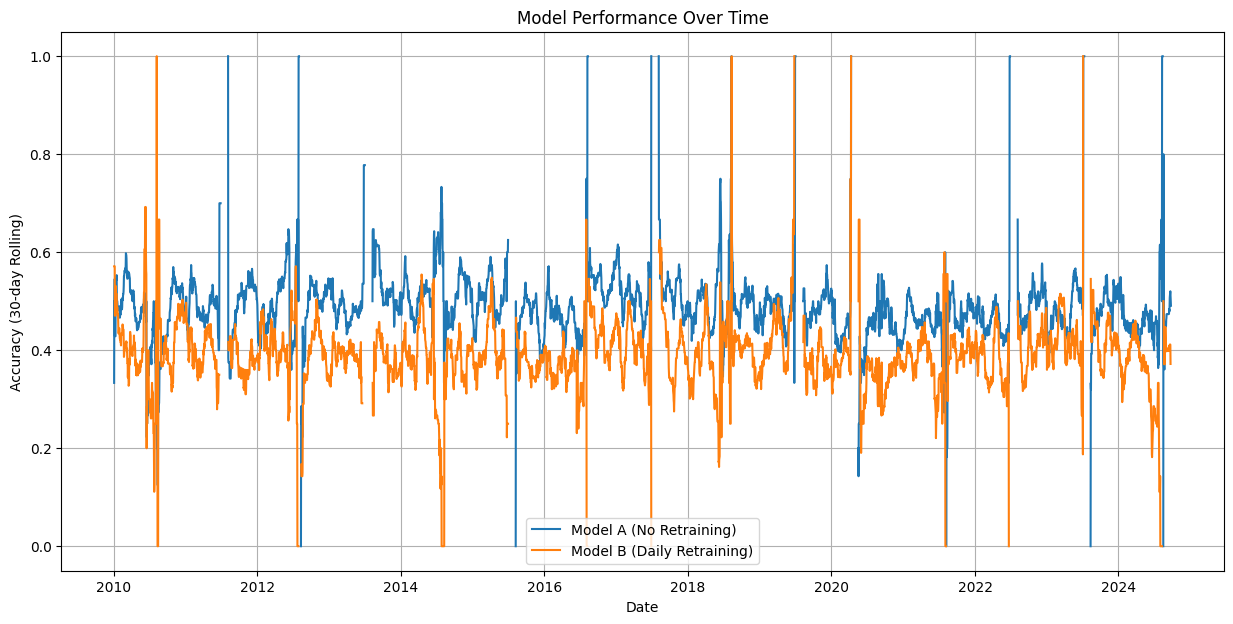

In [30]:
# Example pipeline (replace with your actual pipeline)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier())
])

# Set parameters
preliminary_train_stop_date = '2010-01-01'
evaluation_start_date = '2010-01-01'
evaluation_end_date = '2024-12-31'

# Evaluate models over time
metrics_df_A, metrics_df_B = evaluate_models_over_time(
    df_all=df_all,
    X_col=X_col,
    Y_col=Y_col,
    preliminary_train_stop_date=preliminary_train_stop_date,
    evaluation_start_date=evaluation_start_date,
    evaluation_end_date=evaluation_end_date,
    pipeline=pipeline
)

Processing Model B: 100%|██████████| 2829/2829 [3:31:24<00:00,  4.48s/it]  


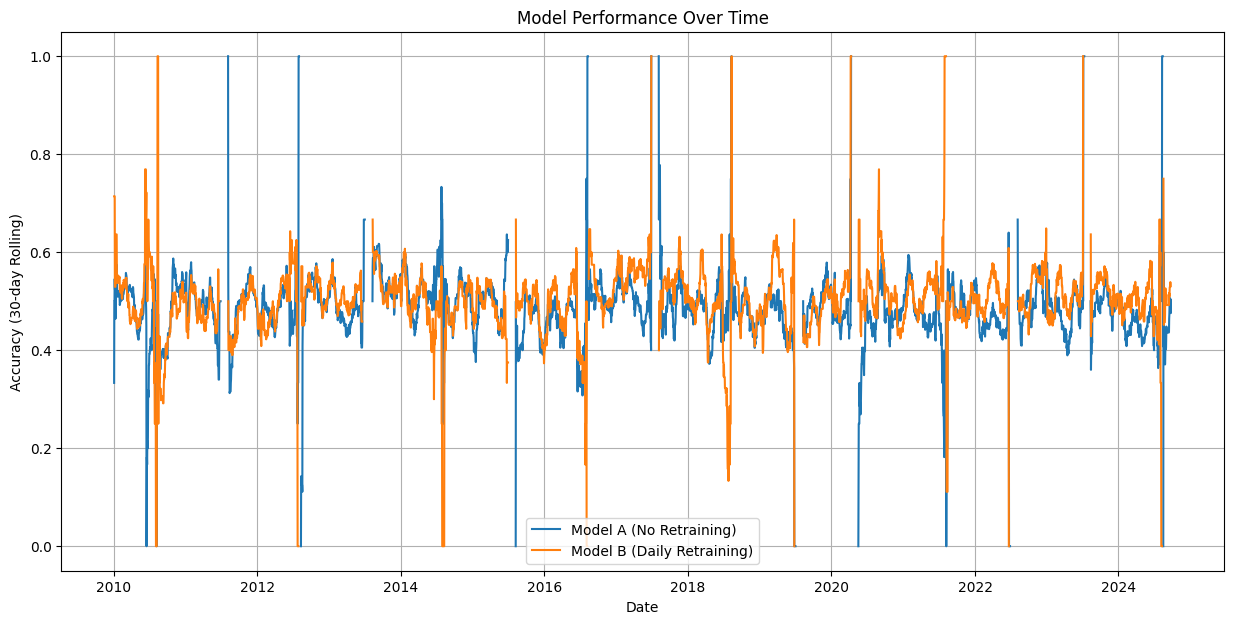

In [32]:
# Example pipeline (replace with your actual pipeline)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier())
])

# Set parameters
preliminary_train_stop_date = '2010-01-01'
evaluation_start_date = '2010-01-01'
evaluation_end_date = '2024-12-31'

# Evaluate models over time
metrics_df_A, metrics_df_B = evaluate_models_over_time(
    df_all=df_all,
    X_col=X_col,
    Y_col=Y_col,
    preliminary_train_stop_date=preliminary_train_stop_date,
    evaluation_start_date=evaluation_start_date,
    evaluation_end_date=evaluation_end_date,
    pipeline=pipeline
)

Window Size: 120 days


Computing metrics: 100%|██████████| 5377/5377 [04:09<00:00, 21.57it/s]


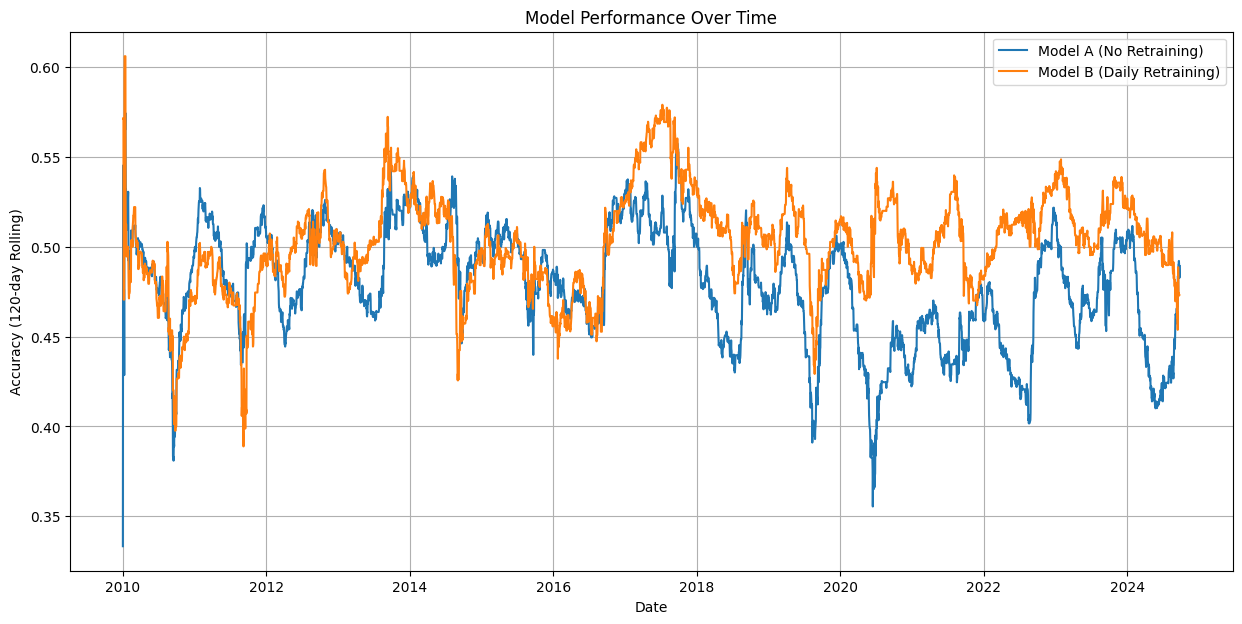

In [76]:
# Example pipeline (replace with your actual pipeline)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier())
])

# Set parameters
preliminary_train_stop_date = '2010-01-01'
evaluation_start_date = '2010-01-01'
evaluation_end_date = '2025-01-01'


window_size_days = 120
print(f"Window Size: {window_size_days} days")
# Evaluate models over time
metrics_df_A, metrics_df_B = evaluate_models_over_time(
    df_all=df_all,
    X_col=X_col,
    Y_col=Y_col,
    preliminary_train_stop_date=preliminary_train_stop_date,
    evaluation_start_date=evaluation_start_date,
    evaluation_end_date=evaluation_end_date,
    pipeline=pipeline,
    window_size_days=window_size_days
)

In [67]:
id = str(uuid.uuid4())
metrics_df_A.to_csv(f"metrics_df_A_{window_size_days}_{preliminary_train_stop_date}_{evaluation_start_date}_{evaluation_end_date}_{id[:4]}.csv")

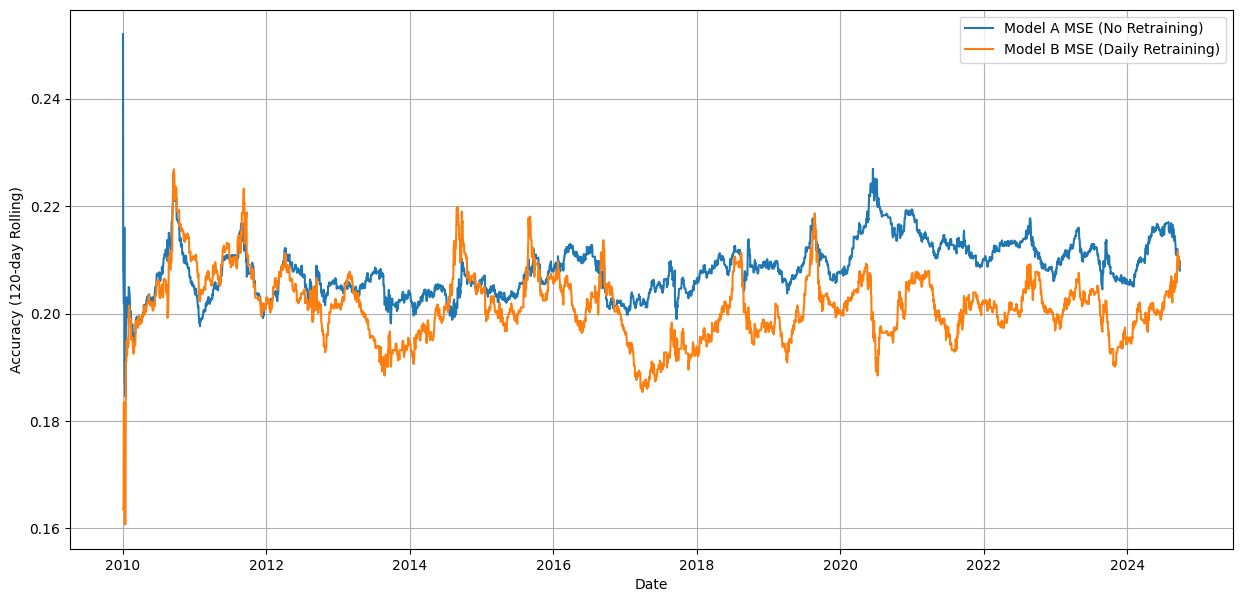

In [83]:
plt.figure(figsize=(15, 7))
plt.plot(metrics_df_A['date'], metrics_df_A['mse_loss'], label='Model A MSE (No Retraining)')
plt.plot(metrics_df_B['date'], metrics_df_B['mse_loss'], label='Model B MSE (Daily Retraining)')
plt.xlabel('Date')
plt.ylabel(f'Accuracy ({window_size_days}-day Rolling)')
#plt.title('Models mse rolling average Over Time')
plt.legend()
plt.grid(True)
plt.show()

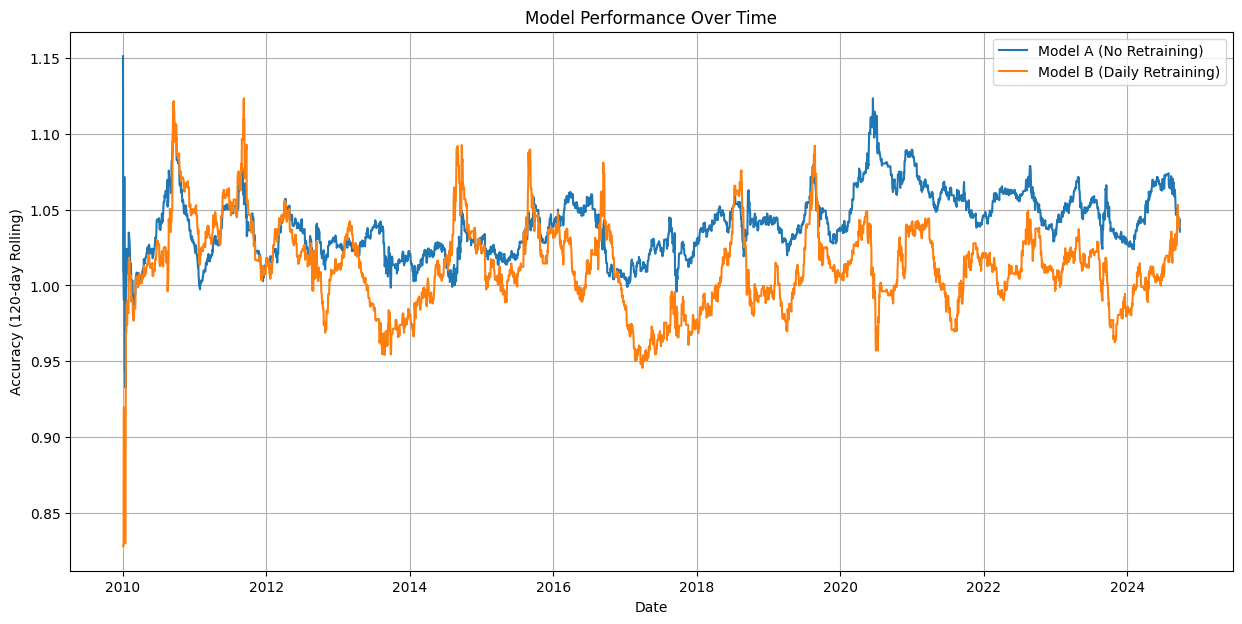

In [78]:
plt.figure(figsize=(15, 7))
plt.plot(metrics_df_A['date'], metrics_df_A['log_loss'], label='Model A (No Retraining)')
plt.plot(metrics_df_B['date'], metrics_df_B['log_loss'], label='Model B (Daily Retraining)')
plt.xlabel('Date')
plt.ylabel(f'Accuracy ({window_size_days}-day Rolling)')
plt.title('Model Performance Over Time')
plt.legend()
plt.grid(True)
plt.show()

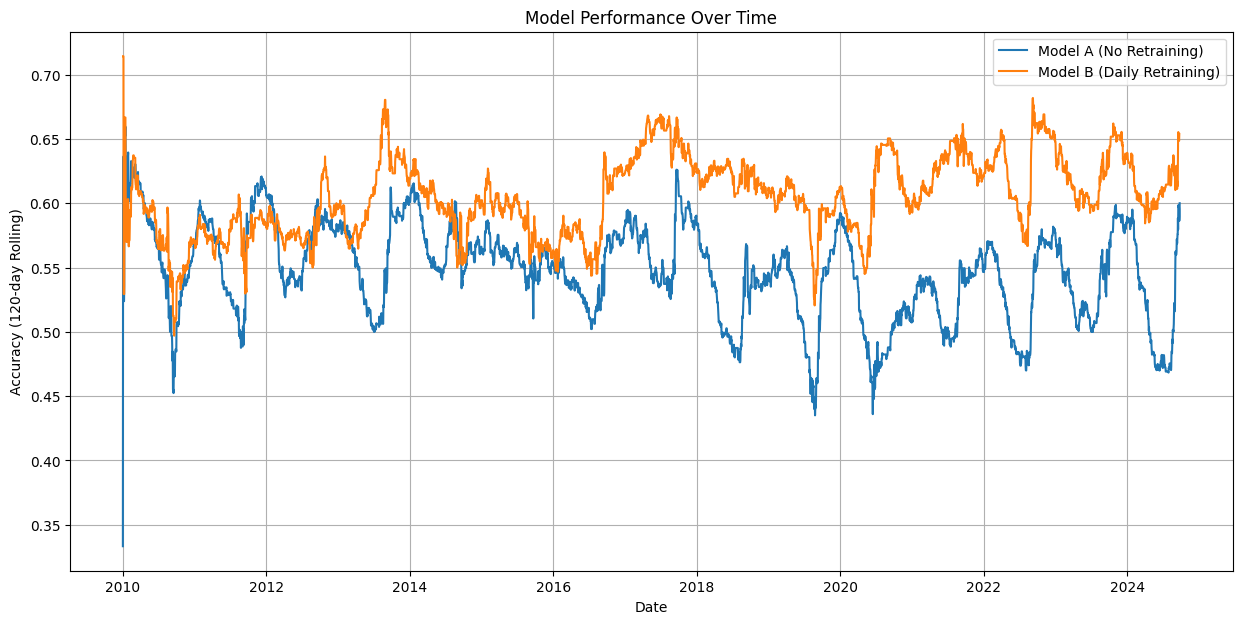

In [81]:
plt.figure(figsize=(15, 7))
plt.plot(metrics_df_A['date'], metrics_df_A['accuracy_home'], label='Model A (No Retraining)')
plt.plot(metrics_df_B['date'], metrics_df_B['accuracy_home'], label='Model B (Daily Retraining)')
plt.xlabel('Date')
plt.ylabel(f'Accuracy ({window_size_days}-day Rolling)')
plt.title('Model Performance Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [62]:
metrics_df_A = pd.read_csv("metrics_df_A_ead70af8-069f-4580-a614-512ad9f499ac_60.csv")
metrics_df_B = pd.read_csv("metrics_df_B_ead70af8-069f-4580-a614-512ad9f499ac_60.csv")
metrics_df_A['date'] = pd.to_datetime(metrics_df_A['date'])
metrics_df_B['date'] = pd.to_datetime(metrics_df_B['date'])
metrics_df_A.columns

Index(['Unnamed: 0', 'date', 'accuracy', 'weighted_accuracy', 'accuracy_home',
       'accuracy_draw', 'accuracy_away', 'macro_avg_precision',
       'micro_avg_precision', 'weighted_precision', 'precision_home',
       'precision_draw', 'precision_away', 'macro_avg_recall',
       'micro_avg_recall', 'weighted_recall', 'recall_home', 'recall_draw',
       'recall_away', 'macro_avg_f_mesure', 'micro_avg_f_mesure',
       'weighted_f_mesure', 'f_mesure_home', 'f_mesure_draw', 'f_mesure_away',
       'log_loss', 'loss_home', 'loss_draw', 'loss_away', 'mse_loss', 'ECE',
       'ECE_home', 'ECE_draw', 'ECE_away', 'home_ECE_y', 'draw_ECE_y',
       'away_ECE_y', 'home_ECE_p', 'draw_ECE_p', 'away_ECE_p', 'home_ECE_size',
       'draw_ECE_size', 'away_ECE_size'],
      dtype='object')

In [33]:
metrics_df_A.to_csv('metrics_df_A.csv', index=False)
metrics_df_B.to_csv('metrics_df_B.csv', index=False)

In [36]:
metrics_df_A.mean(), metrics_df_B.mean()

(date        2017-05-14 12:00:00
 accuracy               0.484619
 dtype: object,
 date        2017-05-14 00:00:00
 accuracy               0.501231
 dtype: object)

In [56]:
plt.figure(figsize=(15, 7))
plt.plot(metrics_df_A['date'], metrics_df_A['mse'], label='Model A (No Retraining)')
plt.plot(metrics_df_B['date'], metrics_df_B['mse'], label='Model B (Daily Retraining)')
plt.xlabel('Date')
plt.ylabel('Accuracy (30-day Rolling)')
plt.title('Model Performance Over Time')
plt.legend()
plt.grid(True)
plt.show()

KeyError: 'mse'

<Figure size 1500x700 with 0 Axes>